# Chapter 14 - Computer Vision

## 14.1. Image Augmentation

*Image augmentation* generates similar but distinct training examples after a series of random changes to the training images, thereby expanding the size of the training set.

Alternatively, image augmentation can be motivated by the fact that random tweaks of training examples allow models to rely less on certain attributes, thereby improving their generalization ability.

In [1]:
%matplotlib inline
import torch
import torchvision
from torch import nn

from d2l import torch as d2l

### 14.1.1. Common Image Augmentation Methods

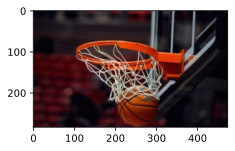

In [2]:
d2l.set_figsize()
img = d2l.Image.open('../imgs/ch14/OIP.jpg')
d2l.plt.imshow(img);

In [4]:
img.size

(474, 284)

In [7]:
def apply(img, aug, num_rows=2, num_cols=4, scale=1.5):
    '''Apply the transformation `aug` for `num_rows` x `num_cols` times
    and display all the results.
    
    Parameters
    ----------
    img : PIL.Image
        The image to apply the transformation.
    aug : class instance
        The transformation class instance.
    num_rows : int
        Number of rows for plotting.
    num_cols : int
        Number of columns for plotting.
    scale : float
        The scale of the output plot.
    '''
    Y = [aug(img) for _ in range(num_rows * num_cols)]
    d2l.show_images(Y, num_rows, num_cols, scale=scale)

#### 14.1.1.1. Flipping and Cropping

Flipping the image left and right usually does not change the category of the object.

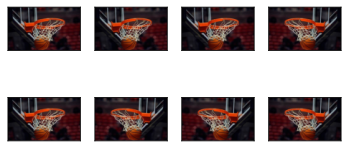

In [10]:
# Horizontal flip (left <-> right) with probability 0.5
apply(
    img,
    torchvision.transforms.RandomHorizontalFlip(), 
)

Flipping up and down is not as common as flipping left and right.

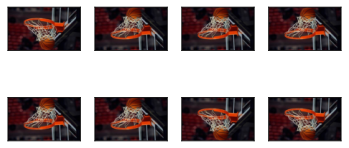

In [9]:
# Vertical flip (up <-> down) with probability 0.5
apply(
    img,
    torchvision.transforms.RandomVerticalFlip(), 
)

The main content of the image may not be located in the center of the image. We can also randomly crop the image to make objects appear in different positions in the image at different scales, which can reduce the sensitivity of a model to the target position.

In the example below, we randomly crop an area with an area of 10% to 100% of the original area each time, and the ratio of width to height of this area is randomly selected from 0.5 to 2. Then, the width and height of the region are both scaled to 200 pixels.

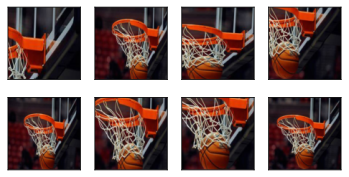

In [11]:
shape_aug = torchvision.transforms.RandomResizedCrop(
    (200, 200), # output shape
    scale=(0.1, 1), # area range of the original image
    ratio=(0.5, 2) # aspect ratio range of the original image
)

apply(
    img,
    shape_aug,
)

#### 14.1.1.2. Changing Colors

To change colors, we can change 4 aspects of the image color: brightness, contrast, saturation, and hue. In the example below, we randomly change the brightness of the image to a value between 50% ($1-0.5$) and 150% ($1+0.5$) of the original image.

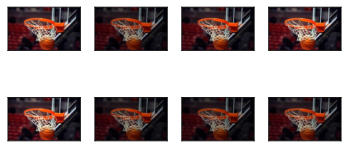

In [13]:
apply(
    img,
    torchvision.transforms.ColorJitter(
        brightness=0.5, # randomly change brightness with a factor in [0.5, 1.5]
        contrast=0,
        saturation=0,
        hue=0,
    )
)

Ranomly change the hue of the image

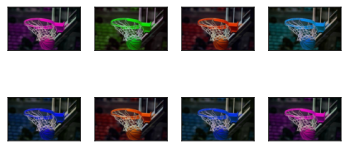

In [14]:
apply(
    img,
    torchvision.transforms.ColorJitter(
        brightness=0,
        contrast=0,
        saturation=0,
        hue=0.5, # randomly change hue with a factor in [0.5, 1.5]
    )
)

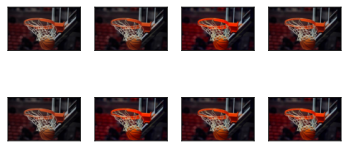

In [15]:
apply(
    img,
    torchvision.transforms.ColorJitter(
        brightness=0,
        contrast=0,
        saturation=0.5, # randomly change saturation with a factor in [0.5, 1.5]
        hue=0,
    )
)

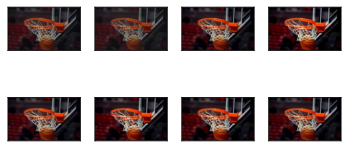

In [18]:
apply(
    img,
    torchvision.transforms.ColorJitter(
        brightness=0,
        contrast=0.5, # randomly change contrast with a factor in [0.5, 1.5]
        saturation=0,
        hue=0,
    )
)

We can also create a `ColorJitter` instance and set how to randomly change the `brightness`, `contrast`, `saturation`, and `hue` of the image at the same time.

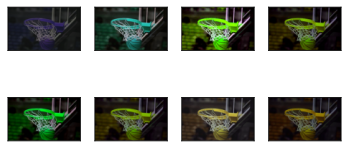

In [19]:
color_aug = torchvision.transforms.ColorJitter(
    brightness=0.5,
    contrast=0.5,
    saturation=0.5,
    hue=0.5,
)

apply(
    img,
    color_aug,
)

#### 14.1.1.3. Combining Multiple Image Augmentation Methods

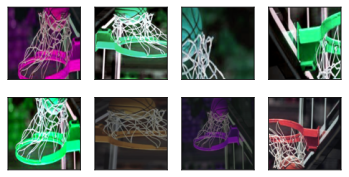

In [21]:
augs = torchvision.transforms.Compose([
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.RandomVerticalFlip(),
    color_aug,
    shape_aug,
])

apply(
    img,
    augs,
)

### 14.1.2. Training with Image Augmentation

Use the CIFAR-10 dataset to demonstrate the effect of image augmentation on computer vision tasks.

Files already downloaded and verified


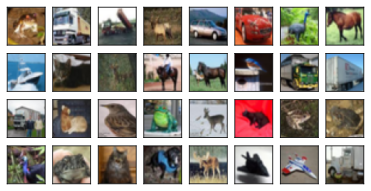

In [23]:
all_images = torchvision.datasets.CIFAR10(train=True,
                                          root="../data",
                                          download=True)

d2l.show_images(
    [all_images[i][0] for i in range(32)],
    4,
    8,
    scale=0.8,
);

In order to obtain definitive results during prediction, we usually only apply image augmentation to training examples, and do not use image augmentation with random operations during prediction.

The `ToTensor` instance is used to convert a minibatch of images into the format required by the deep learning framework, i.e., 32-bit floating point numbers between 0 and 1 with the shape of (batch_size, number of channels, height, width).

In [24]:
train_augs = torchvision.transforms.Compose([
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor(),
])

test_augs = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
])

In [25]:
def load_cifar10(is_train, augs, batch_size):
    '''Load the CIFAR-10 dataset.
    
    Parameters
    ----------
    is_train : bool
        Whether to load the training set or the test set.
    augs : class instance
        The transformation class instance.
    batch_size : int
        The batch size of the data loader.
        
    Returns
    -------
    d2l.DataLoader
        The data loader.
    '''
    dataset = torchvision.datasets.CIFAR10(
        root="../data",
        train=is_train,
        transform=augs, # transformation
        download=True,
    )

    dataloader = torch.utils.data.DataLoader(
        dataset, # dataset
        batch_size=batch_size, # batch size
        shuffle=is_train, # shuffle
        num_workers=d2l.get_dataloader_workers(), # number of subprocesses for data loading
    )

    return dataloader

#### 14.1.2.1. GPU Training

In [28]:
def train_batch(net, X, y, loss, trainer, devices):
    '''Train for a minibatch with GPUs
    
    Parameters
    ----------
    net : torch.nn.Module
        The neural network.
    X : torch.Tensor
        The input tensor.
    y : torch.Tensor
        The ground truth tensor.
    loss : torch.nn.Module
        The loss function.
    trainer : torch.optim.Optimizer
        The optimizer.
    devices : list
        The list of GPUs.
        
    Returns
    -------
    train_loss_sum : torch.Tensor
        The sum of the training loss.
    train_acc_sum : torch.Tensor
        The sum of the training accuracy.
    '''
    if isinstance(X, list):
        # Required for BERT fine-tuning
        X = [x.to(devices[0]) for x in X]
    else:
        X = X.to(devices[0])

    y = y.to(devices[0])
    # Set the model in training mode
    net.train()
    # zero out gradients
    trainer.zero_grad()
    # forward pass
    pred = net(X)
    # compute loss
    l = loss(pred, y)
    # backward pass
    l.sum().backward()
    # update parameters
    trainer.step()

    # record the loss
    train_loss_sum = l.sum()
    # record the acc
    train_acc_sum = d2l.accuracy(pred, y)

    return train_loss_sum, train_acc_sum

In [29]:
def train(net, train_iter, test_iter, loss, trainer, num_epochs, devices=d2l.try_all_gpus()):
    '''Train a model with GPUs
    
    Parameters
    ----------
    net : torch.nn.Module
        The neural network.
    train_iter : d2l.DataLoader
        The training data loader.
    test_iter : d2l.DataLoader
        The test data loader.
    loss : torch.nn.Module
        The loss function.
    trainer : torch.optim.Optimizer
        The optimizer.
    num_epochs : int
        The number of epochs.
    devices : list
        The list of GPUs.
    '''
    timer = d2l.Timer()
    num_batches = len(train_iter)
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0,1],
                            legend=['train loss', 'train acc', 'test acc'])
    
    # initialize the model on multiple GPUs
    net = nn.DataParallel(net, device_ids=devices).to(devices[0])

    for epoch in range(num_epochs):
        # sum of training loss, sum of training accuracy, # of examples, # of predictions
        metric = d2l.Accumulator(4)

        for i, (features, labels) in enumerate(train_iter):
            timer.start()

            l, acc = train_batch(
                net, features, labels, loss, trainer, devices
            )
            metric.add(l, # sum of training loss
                       acc, # sum of training accuracy
                       labels.shape[0], # # of examples
                       labels.numel(), # # of predictions
                       )
            timer.stop()

            if (i+1) % (num_batches//5) == 0 or i == num_batches - 1:
                animator.add(
                    epoch + (i+1) / num_batches,
                    (metric[0] / metric[2], # avg training loss
                     metric[1] / metric[3], # avg training accuracy
                     None) # ignore for now
                )

        test_acc = d2l.evaluate_accuracy_gpu(net, test_iter)
        animator.add(
            epoch + 1,
            (None, 
                None,
            test_acc, # test accuracy
            )
        )

    print(f'loss {metric[0] / metric[2]:.3f}, train acc '
          f'{metric[1] / metric[3]:.3f}, test acc {test_acc:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec on '
          f'{str(devices)}')

The `train_with_data_aug` function is used to train the model with image augmentation.

In [31]:
batch_size = 256
devices = d2l.try_all_gpus()
net = d2l.resnet18(num_classes=10, in_channels=3)
net.apply(d2l.init_cnn)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (resnet_block1): Sequential(
    (0): Residual(
      (conv1): LazyConv2d(0, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv2): LazyConv2d(0, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): LazyBatchNorm2d(0, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn2): LazyBatchNorm2d(0, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): Residual(
      (conv1): LazyConv2d(0, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv2): LazyConv2d(0, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): LazyBatchNorm2d(0, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn2): LazyBatchNorm2d(0, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (resnet_

In [32]:
def train_with_data_aug(train_augs, test_augs, net, lr=0.001):
    '''Train with data augmentation
    
    Parameters
    ----------
    train_augs : class instance
        The transformation class instance for training.
    test_augs : class instance
        The transformation class instance for testing.
    net : torch.nn.Module
        The neural network.
    lr : float
        The learning rate.
    '''
    train_iter = load_cifar10(True, train_augs, batch_size)
    test_iter = load_cifar10(False, test_augs, batch_size)

    loss = nn.CrossEntropyLoss(reduction="none") # loss function (ignores reduction)

    trainer = torch.optim.Adam(net.parameters(), lr=lr)

    net(next(iter(train_iter))[0]) # initialize the model

    train(net, train_iter, test_iter, loss, trainer, 10, devices)

loss 0.201, train acc 0.931, test acc 0.842
344.6 examples/sec on [device(type='cuda', index=0)]


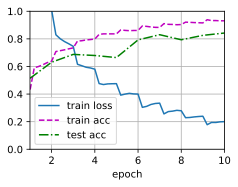

In [33]:
# train with data augmentation
train_with_data_aug(train_augs, test_augs, net)

## 14.2. Fine-Tuning

Suppose that we want to recognize different types of chairs from images, and then recommend purchase links to users. One possible method is to first identify 100 common chairs, take 1000 images of different angles for each chair, and then train a classification model on the collected image dataset. Although this chair dataset may be larger than the Fashion-MNIST dataset, the number of examples is still less than one-tenth of that in ImageNet. This may lead to overfitting of complicated models that are suitable for ImageNet on this chair dataset. Besides, due to the limited amount of training examples, the accuracy of the trained model may not meet practical requirements.

To address this issue, we can apply *transfer learning* to transfer the knowledge learned from the *source dataset* to the *target dataset*. For example, although most of the images in the ImageNet dataset have nothing to do with chairs, the model trained on this dataset may extract more general image features, which can help identify edges, textures, shapes, and object composition. These similar features may also be effective for recognizing chairs.

### 14.2.1. Steps

One common technique in transfer learning is *fine-tuning*. As shown in the figure below, fine-tuning consists of the following four steps:
1. Pretrain a neural network model, i.e., the *source model*, on the source dataset (e.g., the ImageNet dataset).
2. Create a new neural network model, i.e., the *target model*. This copies all model designs and their parameters on the source model except the output layer. Assume that the model parameters contain the knoeledge learned from the source dataset and this knowledge will also be applicable to the target dataset. Also assume that the output layer of the source model is closely related to the labels of the source dataset; thus it is not used in the target model.
3. Add an output layer to the target model, whose number of outputs is the number of categories in the target dataset. Then randomly initialize the model parameters of this layer.
4. Train the target model on the target dataset, such as the chair dataset. The output layer will be trained from scratch, while the parameters of all the other layers are fine-tuned based on the parameters of the source model.

![](../imgs/ch14/finetune.svg)

When target datasets are much smaller than source datasets, fine-tuning helps to improve models' generalization ability.

### 14.2.2. Hot Dog Recognition

We will fine-tune a ResNet model on a small dataset, which was pretrained on ImageNet dataset.

In [1]:
%matplotlib inline
import os
import torch
import torchvision
from torch import nn

from d2l import torch as d2l

#### 14.2.2.1. Reading the Dataset

The hog dog dataset contains 1400 positive-class images containing hot dogs, and as many negative-class images containing other foods. 1000 images of both classes are used for training and the rest are used for testing.

In [2]:
# download the dataset
d2l.DATA_HUB['hotdog'] = (d2l.DATA_URL + 'hotdog.zip',
                          'fba480ffa8aa7e0febbb511d181409f899b9baa5')
data_dir = d2l.download_extract('hotdog')

In [3]:
data_dir

'../data\\hotdog'

In [4]:
# create training and test datasets
train_imgs = torchvision.datasets.ImageFolder(os.path.join(data_dir, 'train'))
test_imgs = torchvision.datasets.ImageFolder(os.path.join(data_dir, 'test'))

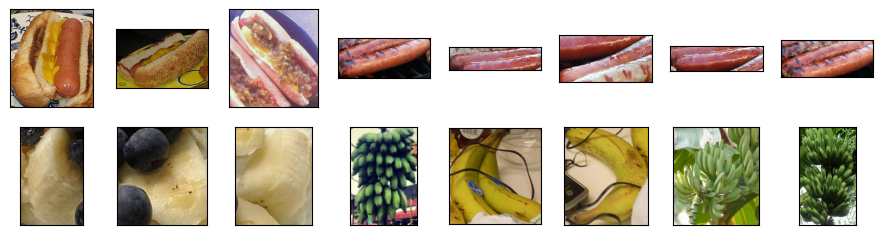

In [5]:
num_examples = 8
hotdogs = [train_imgs[i][0] for i in range(num_examples)]
not_hotdogs = [train_imgs[-i-1][0] for i in range(num_examples)]

d2l.show_images(hotdogs + not_hotdogs, 2, num_examples, scale=1.4);

During training,
1. crop a random area of random size and random aspect ratio from the image,
2. scale this area to a $224 \times 224$ input image.

During testing,
1. scale both the height and width of an image to 256 pixels,
2. crop a central $224 \times 224$ area as input.

For the three RGB color channels, we *standardize* their values channel by channel.

In [6]:
# specify the means and standard deviations of the three RGB channels 
# to standardize the image channel
normalize = torchvision.transforms.Normalize(
    [0.485, 0.456, 0.406], # mean
    [0.229, 0.224, 0.225] # std
)

# training augmentation
train_augs = torchvision.transforms.Compose([
    torchvision.transforms.RandomResizedCrop(224), # resize and crop
    torchvision.transforms.RandomHorizontalFlip(), # flip horizontally
    torchvision.transforms.ToTensor(), # to tensor
    normalize, # normalize
])

# test augmentation
test_augs = torchvision.transforms.Compose([
    torchvision.transforms.Resize([256, 256]), # resize
    torchvision.transforms.CenterCrop(224), # center crop
    torchvision.transforms.ToTensor(), # to tensor
    normalize, # normalize
])

#### 14.2.2.2. Defining and Initializing the Model

We use ResNet-18, which was pretrained on the ImageNet dataset, as the source model.

In [8]:
# load resnet18 weights
from torchvision.models import ResNet18_Weights
weights = ResNet18_Weights.DEFAULT

In [9]:
pretrained_net = torchvision.models.resnet18(weights=weights)

The pretrained source model instance contains a number of feature layers and an output layer `fc`. The member variable `fc` of source model is given below:

In [10]:
pretrained_net.fc

Linear(in_features=512, out_features=1000, bias=True)

As a fully connected layer, it transforms ResNet’s final global average pooling outputs into 1000 class outputs of the ImageNet dataset. We then construct a new neural network as the target model. It is defined in the same way as the pretrained source model except that its number of outputs in the final layer is set to the number of classes in the target dataset (rather than 1000).

In the target model, the model parameters before the output layer of the target model instance `finetune_net` are initialized to model parameters of the corresponding layers from the source model. These model parameters were obtained via pretraining on ImageNet, and we can only use a small learning rate to ***fine-tune*** such pretrained parameters. In contrast, model parameters in the output layer are randomly initialized and generally require a larger learning rate to be learned from scratch.

Letting the base learning rate be $\eta$, a learning rate of $10\eta$ will be used to iterate the model parameters in the output layer.

In [11]:
# initialize a target network
finetune_net = torchvision.models.resnet18(weights=weights)
# replace the output layer
finetune_net.fc = nn.Linear(finetune_net.fc.in_features, # input size
                            2, # output size
                            )
# initialize the fc layer
nn.init.xavier_uniform_(finetune_net.fc.weight)

Parameter containing:
tensor([[ 0.0204, -0.0412,  0.0935,  ...,  0.0323, -0.0698, -0.0960],
        [ 0.0662, -0.0130, -0.0192,  ..., -0.0923, -0.0629,  0.0137]],
       requires_grad=True)

#### 14.2.2.3. Fine-Tuning the Model

First, we define a training function `train_fine_tuning` that uses fine-tuning so it can be called multiple times.

In [12]:
def train_fine_tuning(net, learning_rate, batch_size=128, num_epochs=5, params_group=True):
    '''Fine-tune a model
    
    Parameters
    ----------
    net : torch.nn.Module
        The neural network.
    learning_rate : float
        The learning rate.
    batch_size : int
        The batch size.
    num_epochs : int
        The number of epochs.
    params_group : bool
        If `param_group is True`, the model parameters in the output layer will be
        updated using a learning rate 10 times greater than `learning_rate`. Default is True.
    '''
    # load data batches
    train_iter = torch.utils.data.DataLoader(
        torchvision.datasets.ImageFolder(os.path.join(data_dir, 'train'),
                                         transform=train_augs),
        batch_size=batch_size,
        shuffle=True,
    )
    test_iter = torch.utils.data.DataLoader(
        torchvision.datasets.ImageFolder(os.path.join(data_dir, 'test'),
                                         transform=test_augs),
        batch_size=batch_size,
        shuffle=False,
    )
    # check devices
    devices = d2l.try_all_gpus()
    # loss function
    loss = nn.CrossEntropyLoss(reduction="none")

    if params_group:
        params_1x = [param for name, param in net.named_parameters()
                     if name not in ['fc.weight', 'fc.bias']]
        
        trainer = torch.optim.SGD(
            [
                {'params': params_1x}, # learning rate 1x
                {'params': net.fc.parameters(), 'lr': learning_rate * 10}, # learning rate 10x
            ],
            lr=learning_rate, # global learning rate
            weight_decay=0.001, # weight decay
        )
    else:
        trainer = torch.optim.SGD(
            net.parameters(),
            lr=learning_rate,
            weight_decay=0.001,
        )

    d2l.train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs, devices)

We set the base learning rate to a small value in order to *fine-tune* the model parameters obtained via pretraining. Based on the previous settings, we will train the output layer parameters of the target model from scratch using a learning rate ten times greater.

loss 0.226, train acc 0.923, test acc 0.910
91.1 examples/sec on [device(type='cuda', index=0)]


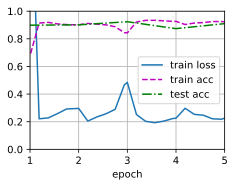

In [13]:
train_fine_tuning(finetune_net, learning_rate=5e-5)

We also define an identical model but initialize all of its model parameters to random values. Since it is trained from scratch, we will use a greater learning rate.

loss 0.378, train acc 0.834, test acc 0.843
99.7 examples/sec on [device(type='cuda', index=0)]


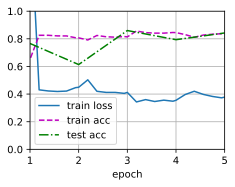

In [14]:
scratch_net = torchvision.models.resnet18()
# replace the output layer
scratch_net.fc = nn.Linear(scratch_net.fc.in_features, 2)

train_fine_tuning(scratch_net, # train from scratch
                  learning_rate=5e-4, # learning rate
                  params_group=False, # do not use different learning rates
                  )

As we can see, the fine-tuned model tends to perform better for the same epoch because its initial parameter values are more effective.

## 14.3. Object Detection

In image classification tasks, we assume that there is only *one major object* in the image and we only focus on how to recognize its category.

The *object detection* (or *object recognition*) is to identify multiple objects of various categories in the image and indicate their categories and locations with *bounding boxes*.

In [15]:
%matplotlib inline
import torch

from d2l import torch as d2l

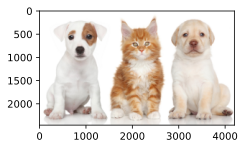

In [16]:
d2l.set_figsize()
# read the image
img = d2l.plt.imread('../imgs/ch14/catdogs.jpg')
d2l.plt.imshow(img);

### 14.3.1. Bounding Boxes

In object detection, we usually use a *bounding box* to describe the spatial location of an object. 

The bounding box is a rectangular box, which is determined by 
1. the $x$ and $y$ coordinates of the upper-left corner of the rectangle and the $x$ and $y$ coordinates of the lower-right corner, or
2. the $(x,y)$ coordinates of the center of the rectangle, and the width and height of the rectangle.

The functions below convert between these two representations.

In [17]:
def box_corner_to_center(boxes):
    '''Convert from (upper-left, bottom-right) to (center, width, height)'''
    x1, y1, x2, y2 = boxes[:, 0], boxes[:, 1], boxes[:, 2], boxes[:, 3]

    # center
    cx = (x1 + x2) / 2
    cy = (y1 + y2) / 2
    # width
    w = x2 - x1
    # height
    h = y2 - y1

    boxes = torch.stack((cx, cy, w, h), axis=-1)
    return boxes

def box_center_to_corner(boxes):
    '''Convert from (center, width, height) to (upper-left, bottom-right)'''
    cx, cy, w, h = boxes[:, 0], boxes[:, 1], boxes[:, 2], boxes[:, 3]

    # upper-left
    x1 = cx - 0.5 * w
    y1 = cy - 0.5 * h
    # bottom-right
    x2 = cx + 0.5 * w
    y2 = cy + 0.5 * h

    boxes = torch.stack((x1, y1, x2, y2), axis=-1)
    return boxes

The origin of the coordinates in the image is the upper-left corner of the image, and to the right and down are the positive directions of the $x$ and $y$ axes, respectively.

In [48]:
dog1_bbox = [60.0, 105.0, 1500.0, 2350.0]
dog2_bbox = [1550.0, 112.0, 2655.0, 2411.0]
cat_bbox = [2750.0, 160.0, 4120.0, 2311.0]

Verify the correctness of the bounding box conversion functions by converting twice:

In [49]:
boxes = torch.tensor((dog1_bbox, dog2_bbox, cat_bbox))
box_center_to_corner(box_corner_to_center(boxes)) == boxes

tensor([[True, True, True, True],
        [True, True, True, True],
        [True, True, True, True]])

In [50]:
def bbox_to_rect(bbox, color):
    '''Convert bounding box to matplotlib format'''
    # convert the bounding box (upper-left x, upper-left y, bottom-right x, bottom-right y) format
    # to matplotlib format: ((upper-left x, upper-left y), width, height)
    return d2l.plt.Rectangle(
        xy=(bbox[0], bbox[1]), # upper-left
        width=bbox[2] - bbox[0], # width
        height=bbox[3] - bbox[1], # height
        fill=False, # no fill
        edgecolor=color, # color
        linewidth=2, # line width
    )

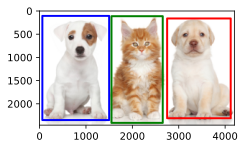

In [51]:
fig = d2l.plt.imshow(img)

# draw bounding boxes
fig.axes.add_patch(bbox_to_rect(dog1_bbox, 'blue'))
fig.axes.add_patch(bbox_to_rect(dog2_bbox, 'green'))
fig.axes.add_patch(bbox_to_rect(cat_bbox, 'red'));

Object detection not only recognizes all the objects of interest in the image, but also their positions. The position is generally represented by a rectangular bounding box.

## 14.4. Anchor Boxes